# Mixture Density Networks with TensorFlow

This post uses TensorFlow to implement the classic [Mixture Density Networks](http://research.microsoft.com/en-us/um/people/cmbishop/downloads/Bishop-NCRG-94-004.pdf) (Bishop '94) model. 

A decent reference on MDNs: [https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)

Source: http://otoro.net/ml/ipynb/mixture/mixture.html.

NOTE: Adapted for use on datahub.ucsd.edu with TF 1.12 rtwomey@ucsd.edu, spring 2019.

## Simple Data Fitting with TensorFlow

To get started, let's try to quickly build a neural network to fit some fake data.  As neural nets of even one hidden layer can be universal function approximators, we can see if we can train a simple neural network to fit a noisy sinusoidal data, like this ($\epsilon$ is just standard gaussian random noise):

$$y=7.0 \sin( 0.75 x) + 0.5 x + \epsilon$$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



<p>After importing the libraries, we generate the sinusoidal data we will train a neural net to fit later:</p>


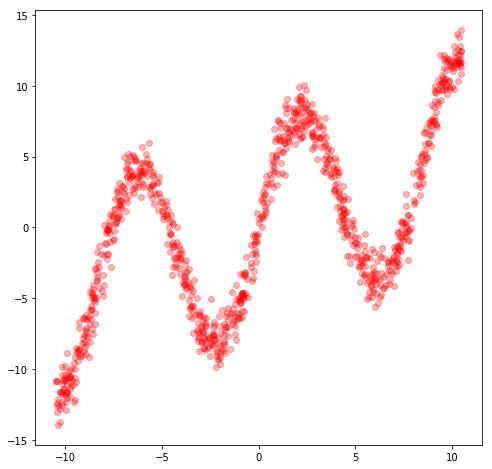

In [2]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

TensorFlow uses _place holders_ as variables that will eventually hold data, to do symbolic computations on the graph later on.

In [3]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

We will define this simple neural network one-hidden layer and 20 nodes:

$$ Y = W_{out} \tanh( W X + b) + b_{out} $$

In [4]:
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

We can define a _loss function_ as the sum of square error of the output vs the data (we can add regularisation if we want). Here we use [l2 loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss).

In [5]:
lossfunc = tf.nn.l2_loss(y_out-y);

We will also define a _training operator_ that will tell TensorFlow to minimise the loss function later.  With just a line, we can use the fancy _RMSProp_ gradient descent optimisation method.

__Notes:__ 
- learning_rate is 0.1
- [RMSProp](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer)


In [6]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)

To start using TensorFlow to compute things, we have to define a _session_ object.  In an IPython shell, we use ```InteractiveSession```.  Afterwards, we need to run a command to initialise all variables, where the computation graph will also be built inside TensorFlow.


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

We will run gradient descent for 1000 times to minimise the loss function with the data fed in via a dictionary.  As the dataset is not large, we won't use mini batches.  After the below is run, the weight and bias parameters will be auto stored in their respective ```tf.Variable``` objects.

In [8]:
NEPOCH = 1000
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

What I like about the API is that we can simply use ```sess.run()``` again to generate data from any operator or node within the network.  So after the training is finished, we can just use the trained model, and another call to ```sess.run()``` to generate the predictions, and plot the predicted data vs the training data set.

We should also ```close()``` the session afterwards to free resources when we are done with this exercise.

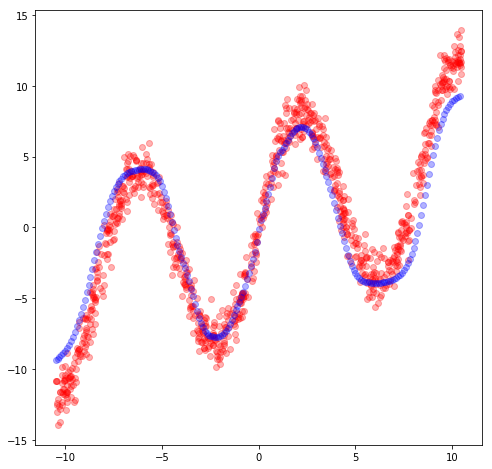

In [9]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

We see that the neural network can fit this sinusoidal data quite well, as expected.  However, this type of fitting method only works well when the function we want to approximate with the neural net is a one-to-one, or many-to-one function.  Take for example, if we invert the training data:

$$x=7.0 \sin( 0.75 y) + 0.5 y+ \epsilon$$

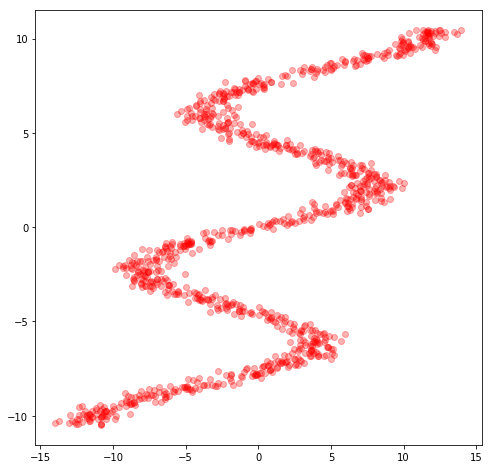

In [10]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()


<p>If we were to use the same method to fit this inverted data, obviously it wouldn't work well, and we would expect to see a neural network trained to fit only to the square mean of the data.</p>


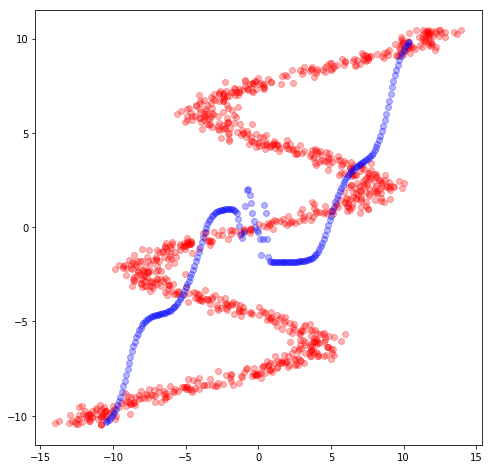

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

Our current model only predicts one output value for each input, so this approach will fail miserably.  What we want is a model that has the capacity to predict a range of different output values for each input.  In the next section we implement a Mixture Density Network (MDN) to do achieve this task.

## Mixture density networks

Mixture Density Networks (MDNs), developed by <a href="http://research.microsoft.com/en-us/um/people/cmbishop/">Christopher Bishop</a> in the 90's, attempt to address this problem.  The approach is rather to have the network predict a single output value, the network is to predict an entire _probability distribution_ for the output.  This concept is quite powerful, and can be employed many current areas of machine learning research.  It also allows us to calculate some sort of confidence factor in the predictions that the network is making.

The inverse sinusoidal data we chose is not just for a toy problem, as there are applications in the field of robotics, for example, where we want to determine which angle we need to move the robot arm to achieve a target location.  MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.


Bishop's implementation of MDNs will predict a class of probability distributions called _Mixture Gaussian_ distributions, where the output value is modelled as a sum of many gaussian random values, each with different means and standard deviations.  So for each input $x$, we will predict a probability distribution function (pdf) of $P(Y = y | X = x)$ that is a probability weighted sum of smaller gaussian probability distributions.

$$P(Y = y | X = x) = \sum_{k=0}^{K-1} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)), \sum_{k=0}^{K-1} \Pi_{k}(x) = 1 $$

Each of the parameters $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ of the distribution will be determined by the neural network, as a function of the input $x$.  There is a restriction that the sum of $\Pi_{k}(x)$ add up to one, to ensure that the pdf integrates to 100%.  In addition, $\sigma_{k}(x)$ must be strictly positive.

In our implementation, we will use a neural network of one hidden later with 24 nodes, and also generate 24 mixtures, hence there will be 72 actual outputs of our neural network of a single input.  Our definition will be split into 2 parts:
$$ Z = W_{o} \tanh( W_{h} X + b_{h}) + b_{o} $$

$Z$ is a vector of 72 values that will be then splitup into three equal parts, $Z_{0\rightarrow23}$, $Z_{24\rightarrow43}$, and $Z_{44\rightarrow71}$

The parameters of the pdf will be defined as below to satisfy the earlier conditions:

$$\Pi_{k} = \frac{\exp(Z_{k})}{\sum_{i=0}^{23} exp(Z_{i})}, \sigma = \exp(Z_{24\rightarrow43}), \mu = Z_{44\rightarrow71}$$<p>$\Pi_{k}$ are essentially put into a _softmax_ operator to ensure that the sum adds to one, and that each mixture probability is positive.  Each $\sigma_{k}$ will also be positive due to the exponential operator.  It gets deeper than this though!  In Bishop's paper, he notes that the softmax and exponential terms have some theoretical interpretations from a Bayesian framework way of looking at probability.  Note that in the actual softmax code, the largest value will divide both numerator and denominator to avoid ```exp``` operator easily blowing up.  In TensorFlow, the network is described below:

In [12]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
  out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
  out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

  out_pi, out_sigma, out_mu = tf.split(output, 3, 1)

  max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
  out_pi = tf.subtract(out_pi, max_pi)

  out_pi = tf.exp(out_pi)

  normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keepdims=True))
  out_pi = tf.multiply(normalize_pi, out_pi)

  out_sigma = tf.exp(out_sigma)

  return out_pi, out_sigma, out_mu

out_pi, out_sigma, out_mu = get_mixture_coef(output)



<p>Let's define the inverted data we want to train our MDN to predict later.  As this is a more involved prediction task, I used a higher number of samples compared to the simple data fitting task earlier.</p>


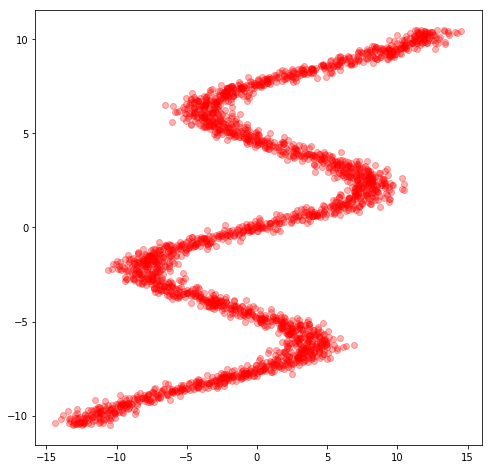

In [13]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

We cannot simply use the min square error L2 lost function in this task the output is an entire description of the probability distribution.  A more suitable loss function is to minimise the logarithm of the likelihood of the distribution vs the training data:
$$CostFunction(y | x) = -\log[ \sum_{k}^K \Pi_{k}(x) \phi(y, \mu(x), \sigma(x)) ]$$

So for every $(x, y)$ point in the training data set, we can compute a cost function based on the predicted distribution versus the actual points, and then attempt the minimise the sum of all the costs combined.  To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We implement this cost function in TensorFlow below as an operation:

In [14]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.

def tf_normal(y, mu, sigma):
  result = tf.subtract(y, mu)
  result = tf.multiply(result,tf.reciprocal(sigma))
  result = -tf.square(result)/2
  return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
  result = tf_normal(y, out_mu, out_sigma)
  result = tf.multiply(result, out_pi)
  result = tf.reduce_sum(result, 1, keepdims=True)
  result = -tf.log(result)
  return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

We will train the model below, while collecting the progress of the loss function over training iterations.  TensorFlow offers some [useful tools](http://tensorflow.org/how_tos/summaries_and_tensorboard/index.html) to visualise training data progress but we didn't use them here.

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

print("training data is {0} and {1}".format(x_data.shape, y_data.shape))

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})
  loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
training data is (2500, 1) and (2500, 1)


As a side note, the impressive thing is that TensorFlow automatically calculated the gradients of the log likelihood cost functions and applied those gradients in the optimisation.  For this problem, actually there are very optimised gradient formulas available (see derivations in Bishop's original [paper](http://research.microsoft.com/en-us/um/people/cmbishop/downloads/Bishop-NCRG-94-004.pdf), equations $33-39$), and I highly doubt the gradient formula TensorFlow calculated automatically will be as optimised and elegant, so there would be room for performance improvements by building a custom operator into TensorFlow with the pre-optimised gradient formulas for this loss function, like they have done for the cross entropy loss function.  I had implemented before the optimised closed-form gradient formulas with all the numerical gradient testing that came with it - if you want to implement it, please make sure you do the gradient testing!  It is difficult to get right the first time.

Let's plot the progress of the training, and see if the cost decreases over iterations:

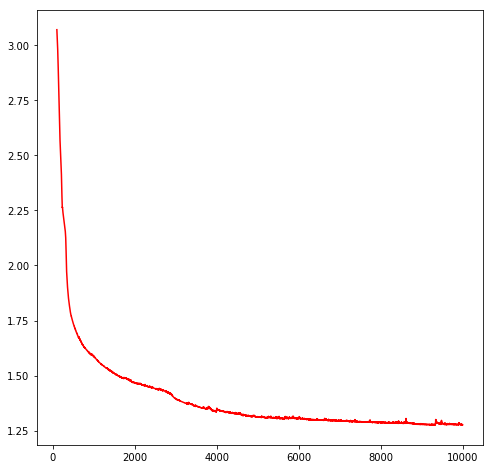

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

We found that it more or less stopped improving after 6000 iterations or so.  The next thing we want to do, is to have the model generate distributions for us, say, across a bunch of points along the x-axis, and then for each distribution, draw 10 points randomly from that distribution, to produce ensembles of generated data on the y-axis.  This gives us a feel of whether the pdf generated matches the training data.

To sample a mixed gaussian distribution, we randomly select which distribution based on the set of $\Pi_{k}$ probabilities, and then proceed to draw the point based off the $k^{th}$ gaussian distribution.

In [17]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print('error with sampling ensemble')
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
  NTEST = x_test.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

Let's see how the generated data looks:

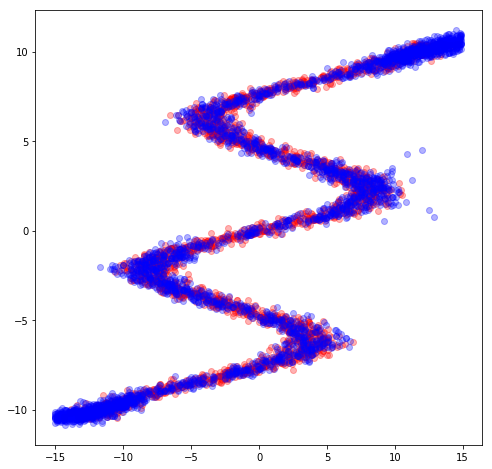

In [18]:
out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

In the above graph, we plot out the generated data we draw out from the MDN distribution, in blue, and plot it over the original training data in red.  Apart from a few outliers, the distributions seem to match the data.  We can also plot a graph of $\mu(x)$ as well, and we see what the neural network is sort of doing.  For every point on the x-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities defined by $\Pi_{k}$.

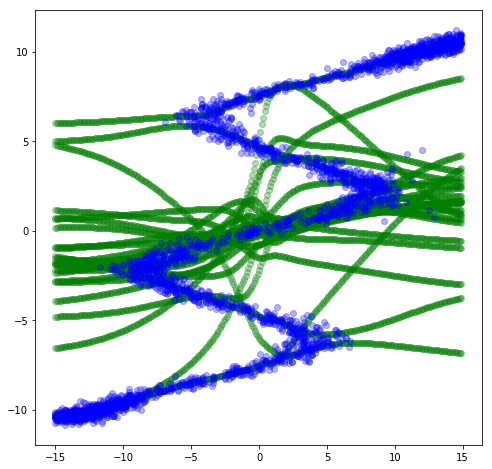

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(x_test,out_mu_test,'go', x_test,y_test,'bo',alpha=0.3)
plt.show()

Lastly, if we want, we can try to draw the entire mixture pdf at each point on the x-axis to get a heatmap.

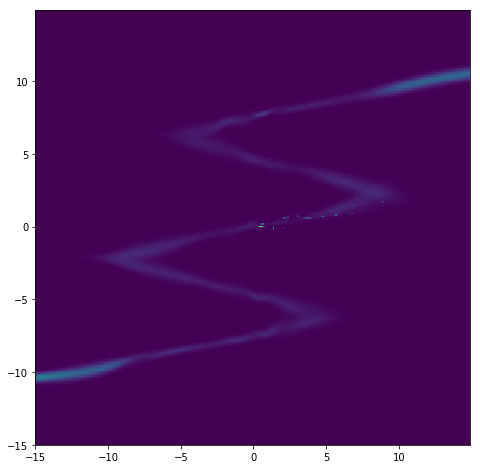

In [20]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

def custom_gaussian(x, mu, std):
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)


<h2 id="Some-Closing-Thoughts">Some Closing Thoughts<a class="anchor-link" href="#Some-Closing-Thoughts">¶</a></h2><ul>
<li>I think MDN's are a great way to model data, especially if what we are modelling have either multiple states, or is inherently a random variable that cannot be predicted with absolute certainty.  I believe even simple single-layer MDN's like these can be put to good use, as they are so simple to build!</li>
<li>TensorFlow has a solid and <em>clean</em> API which will make implementing and testing machine learning algorithms more efficient, especially combined with the IPython stack.</li>
<li>There are many issues related to performance, which needs to be ironed out.  Also, although the library can be used in theory for distributed computing, so far only the non-distributed version has been open sourced.</li>
<li>Symbolic differentiation is great, but at some point would be nice to be able to manually implement efficient <em>solved</em> derivative formulas in a simpler way than adding an operation and having the need to recompile the entire library.  That being said, TensorFlow's symbolic operation seems much faster than Theano's compiling process.</li>
</ul>
